In [373]:
import random
import numpy as np
import pandas as pd
from datetime import timedelta

### Cohortify Example

This notebook will demonstrate how and when to use the `cohortify`. In short, whenever you have right censored observations you can use cohortify to forecast the runout across cohorts. We will demonstrate below what that means..

### Generate Some Random Visitor Data

First we will generate some random  visitor data. Let's assume that we

In [374]:
def random_poisson(val):
    "Generate random count data from different Poisson distributions"
    if val >= 0.5:
        return np.random.poisson(lam=3.0, size=1)
    elif 0.25 > val > 0.5:
        return np.random.poisson(lam=2.0, size=1)
    else:
        return np.random.poisson(lam=7.0, size=1)
    
def filter_lag(visitor, days, lag_dict, val):
    """Given a visit date and sign up lag, return None if the lag is beyond
    the observable timeframe based on the max date"""
    if val > 0.7:
        return None
    dt = visitor[1]
    lag = dt + timedelta(days=days)
    if days > int(lag_dict[dt].days):
        return None
    else:
        return lag
    
from pandas._libs.tslibs.nattype import NaTType

def timedelta2days(delta) -> int:
    "Convert a pandas"
    if type(delta) is NaTType:
        return None
    else:
        return int(delta.days)

In [375]:
# some range of dates
visit_dt_range = pd.date_range(end = pd.datetime.today(), periods = 52).to_pydatetime().tolist()

# assuming 50 visitors a day...
visitors = list(zip(np.arange(0, 50 * len(visit_dt_range)), visit_dt_range * 50))

# unique ids
ids = pd.DataFrame(visitors,  columns=["id","visit_dt"])["id"].tolist()
visit_dt = pd.DataFrame(visitors,  columns=["id","visit_dt"])["visit_dt"].tolist()

# current date
max_visit_dt = max(visit_dt)

# dict of dates correspionding to valid number of lags
lag_dict = {dt: (max_visit_dt - dt) for dt in visit_dt}

# generate some arbitrary signup dates
signup_dt = [filter_lag(dt, int(random_poisson(random.random())[0]), lag_dict, random.random()) for dt in visitors]

# create visitor df
df = pd.DataFrame(list(zip(ids, visit_dt, signup_dt)), columns = ["id", "visit_dt", "signup_dt"])

# calculate lag between visit and signup
df["lag"] = df["signup_dt"] - df["visit_dt"]

# convert timedelta to int
df["lag"] = df["lag"].apply(lambda x: timedelta2days(x))

# create df containing all lag vals
df_lag = pd.DataFrame([[np.nan, NaTType(), NaTType(), n] for n in range(int(df["lag"].max() + 1))], columns=["id", "visit_dt", "signup_dt", "lag"])

#  make sure df contains all lag vals in lag column
df = pd.concat([df, df_lag], axis=0)

df[:10]

,id,visit_dt,signup_dt,lag
0,0.0,2019-06-29 16:00:39.166647,2019-07-04 16:00:39.166647,5.0
1,1.0,2019-06-30 16:00:39.166647,2019-07-07 16:00:39.166647,7.0
2,2.0,2019-07-01 16:00:39.166647,2019-07-03 16:00:39.166647,2.0
3,3.0,2019-07-02 16:00:39.166647,NaT,NaN
4,4.0,2019-07-03 16:00:39.166647,NaT,NaN
5,5.0,2019-07-04 16:00:39.166647,2019-07-10 16:00:39.166647,6.0
6,6.0,2019-07-05 16:00:39.166647,NaT,NaN
7,7.0,2019-07-06 16:00:39.166647,2019-07-09 16:00:39.166647,3.0
8,8.0,2019-07-07 16:00:39.166647,2019-07-13 16:00:39.166647,6.0
9,9.0,2019-07-08 16:00:39.166647,2019-07-10 16:00:39.166647,2.0


### Create Cohort Table from Visitor Logs

In [376]:
# create cohort table from raw id, conversion date fields
cohort = df.pivot_table(columns="visit_dt", index="lag", values="id", aggfunc="count")

# fill empty cells w/ 0 where lag has passed
for dt in cohort.columns:
    lag = lag_dict[dt].days
    cohort[dt] = cohort[dt][: lag].fillna(0.0)
    
cohort[:10]

visit_dt,2019-06-29 16:00:39.166647,2019-06-30 16:00:39.166647,2019-07-01 16:00:39.166647,2019-07-02 16:00:39.166647,2019-07-03 16:00:39.166647,2019-07-04 16:00:39.166647,2019-07-05 16:00:39.166647,2019-07-06 16:00:39.166647,2019-07-07 16:00:39.166647,2019-07-08 16:00:39.166647,...,2019-08-09 16:00:39.166647,2019-08-10 16:00:39.166647,2019-08-11 16:00:39.166647,2019-08-12 16:00:39.166647,2019-08-13 16:00:39.166647,2019-08-14 16:00:39.166647,2019-08-15 16:00:39.166647,2019-08-16 16:00:39.166647,2019-08-17 16:00:39.166647,2019-08-18 16:00:39.166647
lag,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,1.0,2.0,2.0,1.0,3.0,0.0,0.0,1.0,3.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0
1.0,4.0,3.0,1.0,3.0,2.0,3.0,3.0,5.0,3.0,1.0,...,4.0,4.0,4.0,4.0,3.0,0.0,5.0,2.0,2.0,4.0
2.0,3.0,8.0,7.0,3.0,4.0,4.0,7.0,3.0,6.0,3.0,...,6.0,3.0,4.0,1.0,3.0,4.0,1.0,5.0,5.0,NaN
3.0,4.0,7.0,3.0,6.0,5.0,6.0,4.0,5.0,2.0,9.0,...,2.0,4.0,0.0,11.0,7.0,10.0,3.0,10.0,NaN,NaN
4.0,3.0,4.0,6.0,3.0,2.0,4.0,3.0,7.0,4.0,4.0,...,7.0,2.0,4.0,6.0,3.0,0.0,6.0,NaN,NaN,NaN
5.0,8.0,4.0,2.0,2.0,5.0,3.0,3.0,2.0,7.0,1.0,...,3.0,7.0,8.0,0.0,4.0,4.0,NaN,NaN,NaN,NaN
6.0,3.0,2.0,5.0,4.0,9.0,6.0,6.0,4.0,3.0,3.0,...,4.0,2.0,0.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN
7.0,2.0,2.0,3.0,4.0,2.0,3.0,1.0,4.0,2.0,3.0,...,1.0,1.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
8.0,1.0,2.0,3.0,2.0,2.0,2.0,3.0,1.0,2.0,1.0,...,2.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [377]:
# lag 0
lag_0 = cohort.loc[0].values

# signup rate for lag_0 (e.g. visitors who signup on the same day as their first visit)
print(lag_0)
np.mean(lag_0), np.var(lag_0)

[1. 1. 2. 2. 1. 3. 0. 0. 1. 3. 0. 1. 0. 1. 1. 1. 0. 2. 0. 0. 0. 2. 0. 0.
 2. 2. 1. 3. 0. 0. 1. 0. 0. 1. 0. 1. 0. 2. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 4. 0.]


(0.8627450980392157, 0.9811610918877354)

In [378]:
# lag 1
lag_1 = cohort.loc[1].dropna().values

# signup rate for lag_0 (e.g. visitors who signup on the same day as their first visit)
print(lag_1)
np.mean(lag_1), np.var(lag_1)

[4. 3. 1. 3. 2. 3. 3. 5. 3. 1. 1. 1. 3. 3. 2. 2. 2. 2. 5. 2. 6. 3. 3. 0.
 5. 1. 3. 1. 3. 2. 1. 5. 3. 3. 3. 5. 4. 2. 2. 6. 0. 4. 4. 4. 4. 3. 0. 5.
 2. 2. 4.]


(2.823529411764706, 2.2237600922722036)

### Populate the Lower Triangle

Starting w/ the most recent date, let's look at how we can model just the `day 1 lag`.

In [379]:
# given a set of tuples (X, y) -  predict y given X

import numpy as np
from sklearn.linear_model import LinearRegression
from pandas import DataFrame

def train_a_lag_model(cohort: DataFrame, lag: int):
    """Given a df of visitor logs, a cohort table of conversion tranches,...
    """
    n_range = list(range(lag + 1))
    arr = pd.DataFrame(np.array([cohort.loc[n].values for n in n_range]).T).dropna().values
    X = arr[:,: lag]
    y = arr[:, lag]
    return LinearRegression().fit(X, y)

### Train a Model

The objective is to define a method that takes a Cohort table and overlays a forecast on top of it, e.g. populate the lower triangle.

In [380]:
lm_dict = {}

for n in range (1, len(cohort.index)):
    lm_dict[n] = train_a_lag_model(cohort, lag=n)

So we now have a model for each lag.

In [381]:
print("models weights:")

for n in range (1, len(cohort.index)):
    reg = lm_dict[n]
    print("lag:", n)
    print(reg.coef_)
    print(reg.intercept_)

models weights:
lag: 1
[-0.34443574]
3.1206896551724137
lag: 2
[ 0.43736637 -0.15102379]
4.037984218896236
lag: 3
[-0.50429281 -0.42198872 -0.3186607 ]
8.011122267391162
lag: 4
[ 0.39644741 -0.05143023 -0.29208636 -0.21572429]
6.975797941890835
lag: 5
[-0.51534087 -0.03357509 -0.22419519 -0.43214337 -0.19458032]
8.689800058254864
lag: 6
[ 0.00799828 -0.20884723 -0.19820476 -0.01581204 -0.1044661  -0.13179446]
6.39704888059172
lag: 7
[ 0.14631316  0.155573   -0.18286032 -0.0570524   0.0536809  -0.16006262
 -0.04650362]
3.572099860189259
lag: 8
[-0.09610417  0.02871156 -0.03263448 -0.08855886 -0.14296378 -0.17720086
 -0.04522154 -0.12173833]
4.546010058798311
lag: 9
[-0.28486142  0.00353178 -0.01581913 -0.09199761 -0.2665524  -0.25090642
 -0.29083459  0.18087269 -0.1037627 ]
5.935491892522894
lag: 10
[ 0.00484044 -0.02515582 -0.02091121  0.02882033 -0.02469817 -0.09710963
 -0.14113665 -0.21295715 -0.06740625 -0.18017453]
3.363615489937148
lag: 11
[-0.19568445 -0.19967186 -0.07354349 -0.0

What this model is doing is looking within a "cohort" and using the observed values thus far to predict the next "run out" value. So if we are in a cohort with observed runout from t_0 through t_3 it uses [t0, t1, t2, t3] as the covariates to predict t_4.

In [382]:
# array where null

arr = pd.DataFrame(np.array([cohort.loc[n].values for n in range(len(cohort.index))]).T).values
print("cohort array:")
print(arr[-10:])

# get indices we need to predict for
nan_index = np.argwhere(np.isnan(arr))

# sort indices by prediction order
nan_index = nan_index[np.lexsort((nan_index[:, 1], -nan_index[:, 0]))]
print("ordered indices to update:")
print(nan_index[:10])

for i in range (0, len(nan_index)):
    # get array index of first val
    row, col = nan_index[i]

    # get model
    lm = lm_dict[col]

    # get model features
    x = arr[row, :col].reshape(1, -1)

    # predict
    y_hat = lm.predict(np.array(x))[0]

    # update array
    arr[row, col] = int(round(y_hat, 0))

cohort array:
[[ 1.  4.  6.  2.  7.  3.  4.  1.  2.  1.  3. nan nan nan nan nan]
 [ 0.  4.  3.  4.  2.  7.  2.  1.  4.  2. nan nan nan nan nan nan]
 [ 1.  4.  4.  0.  4.  8.  0.  6.  2. nan nan nan nan nan nan nan]
 [ 1.  4.  1. 11.  6.  0.  7.  6. nan nan nan nan nan nan nan nan]
 [ 0.  3.  3.  7.  3.  4.  3. nan nan nan nan nan nan nan nan nan]
 [ 0.  0.  4. 10.  0.  4. nan nan nan nan nan nan nan nan nan nan]
 [ 0.  5.  1.  3.  6. nan nan nan nan nan nan nan nan nan nan nan]
 [ 0.  2.  5. 10. nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 4.  2.  5. nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 0.  4. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
ordered indices to update:
[[50  2]
 [50  3]
 [50  4]
 [50  5]
 [50  6]
 [50  7]
 [50  8]
 [50  9]
 [50 10]
 [50 11]]


In [383]:
visitors = pd.DataFrame(df.groupby("visit_dt").apply(len), columns=["visitors"])
signups_expected = pd.DataFrame(pd.DataFrame(arr.T, index=cohort.index, columns=cohort.columns).sum(), columns=["signups_expected"])
signups_observed = pd.DataFrame(cohort.sum(), columns=["signups_observed"])

runout_df = visitors.join(signups_observed.join(signups_expected))
runout_df["signups_runout"] = runout_df["signups_expected"] - runout_df["signups_observed"]
runout_df["signups_observed_rate"] = runout_df["signups_observed"] / runout_df["visitors"]
runout_df["signups_expected_rate"] = runout_df["signups_expected"] / runout_df["visitors"]

runout_df

,visitors,signups_observed,signups_expected,signups_runout,signups_observed_rate,signups_expected_rate
visit_dt,,,,,,
2019-06-29 16:00:39.166647,50,37.0,37.0,0.0,0.74,0.74
2019-06-30 16:00:39.166647,50,40.0,40.0,0.0,0.80,0.80
2019-07-01 16:00:39.166647,50,39.0,39.0,0.0,0.78,0.78
2019-07-02 16:00:39.166647,50,36.0,36.0,0.0,0.72,0.72
2019-07-03 16:00:39.166647,50,34.0,34.0,0.0,0.68,0.68
2019-07-04 16:00:39.166647,50,38.0,38.0,0.0,0.76,0.76
2019-07-05 16:00:39.166647,50,34.0,34.0,0.0,0.68,0.68
2019-07-06 16:00:39.166647,50,37.0,37.0,0.0,0.74,0.74
2019-07-07 16:00:39.166647,50,36.0,36.0,0.0,0.72,0.72


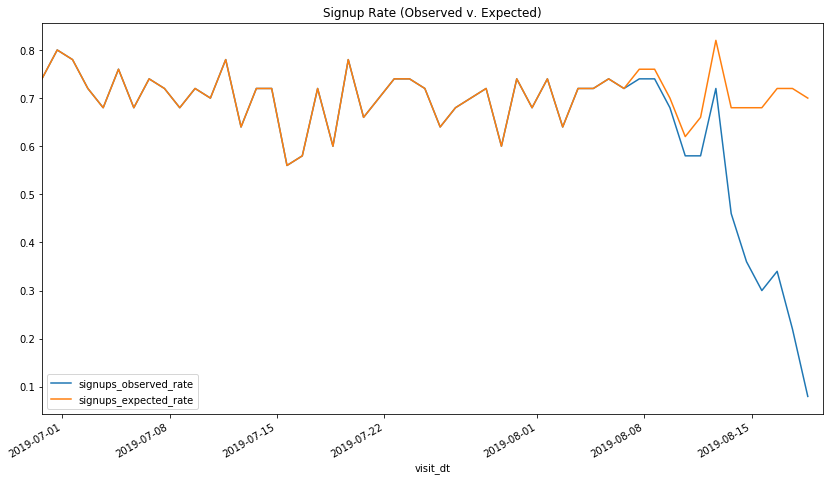

In [389]:
import matplotlib as plt

runout_df[["signups_observed_rate", "signups_expected_rate"]].plot(title="Signup Rate (Observed v. Expected)", figsize=(14, 8));